In [1]:
import sqlite3
import pandas as pd
import fakeInjectionPipeline as fip
import numpy as np
import matplotlib.pyplot as plt

In [2]:
patch_list = ['00', '11', '22', '33', '44', '55', '66']
host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [20, 21, 22, 23, 24]
injection_db_path = './data/table/gal_4639/injection_coord.sqlite'

calexp_info_dict, injection_coord_dict = fip.get_calexp_injection_dict(
    patch_list, host_mag_list, dbpath=injection_db_path
)

In [6]:
conn = sqlite3.connect('./data/patch_0to6/diff/al_default/detection/detection.sqlite')
query = (f"SELECT * FROM fake_src")
fake_src = pd.read_sql_query(query, conn)

In [5]:
forced_db = ('./data/patch_0to6/diff/al_default/forced/forced.sqlite')
conn = sqlite3.connect(forced_db)
forced_flux = pd.read_sql_query('SELECT * FROM forced', conn)

In [7]:
fake_src_det = fake_src.loc[fake_src.matched_status.astype(bool)].copy().reset_index(drop=True)
forced_flux_det = forced_flux.loc[forced_flux.matched_status.astype(bool)].copy().reset_index(drop=True)

In [36]:
forced_flux_det['fake_mag'][0]

b'20'

In [37]:
forced_flux_det['host_mag'] = forced_flux_det['host_mag'].str.decode("utf-8")
forced_flux_det['fake_mag'] = forced_flux_det['fake_mag'].str.decode("utf-8")

In [38]:
patch_list = ['00', '11', '22', '33', '44', '55', '66']
host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [20, 21, 22, 23, 24]

In [39]:
def slice_df(df, equal=None, big=None, small=None):
    # condition list
    cond_ls = []
    if equal:
        for key, item in equal.items():
            cond_ls.append(df.loc[:, key]==item)
    if big:
        for key, item in big.items():
            cond_ls.append(df.loc[:, key]>item)
    if small:
        for key, item in small.items():
            cond_ls.append(df.loc[:, key]<item)
    if not cond_ls:
        return df.copy().reset_index(drop=True)
    else:
        index = np.logical_and.reduce(cond_ls)
        sliced_df = df.loc[index].copy().reset_index(drop=True)
        return sliced_df
def get_residual(fake_src_df, fake_mag):
    res_dict = {}
    fake_mag_str = str(fake_mag).replace('.', '')
    fake_src = slice_df(fake_src_df, equal={'fake_mag': fake_mag_str})
    src_f = fake_src['base_PsfFlux_instFlux']
    injected_f = fake_src['injected_instFlux']
    src_inj = (src_f - injected_f) / injected_f
    return src_inj
def get_forced_residual(fake_src_df, fake_mag):
    res_dict = {}
    fake_mag_str = str(fake_mag).replace('.', '')
    fake_src = slice_df(fake_src_df, equal={'fake_mag': fake_mag_str})
    src_f = fake_src['base_PsfFlux_instFlux_forced']
    injected_f = fake_src['injected_instFlux']
    src_inj = (src_f - injected_f) / injected_f
    return src_inj
def remove_outlier(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    dist_from_mean = abs(arr - mean)
    max_deviations = 5
    not_outlier = dist_from_mean < max_deviations * std
    no_outliers = arr[not_outlier]
    return no_outliers

In [40]:
for pc in violin_parts['bodies']:
    pc.set_facecolor('red')
    pc.set_edgecolor('black')

Series([], dtype: float64)

In [83]:
labels = []
def add_label(violin, label, labels):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

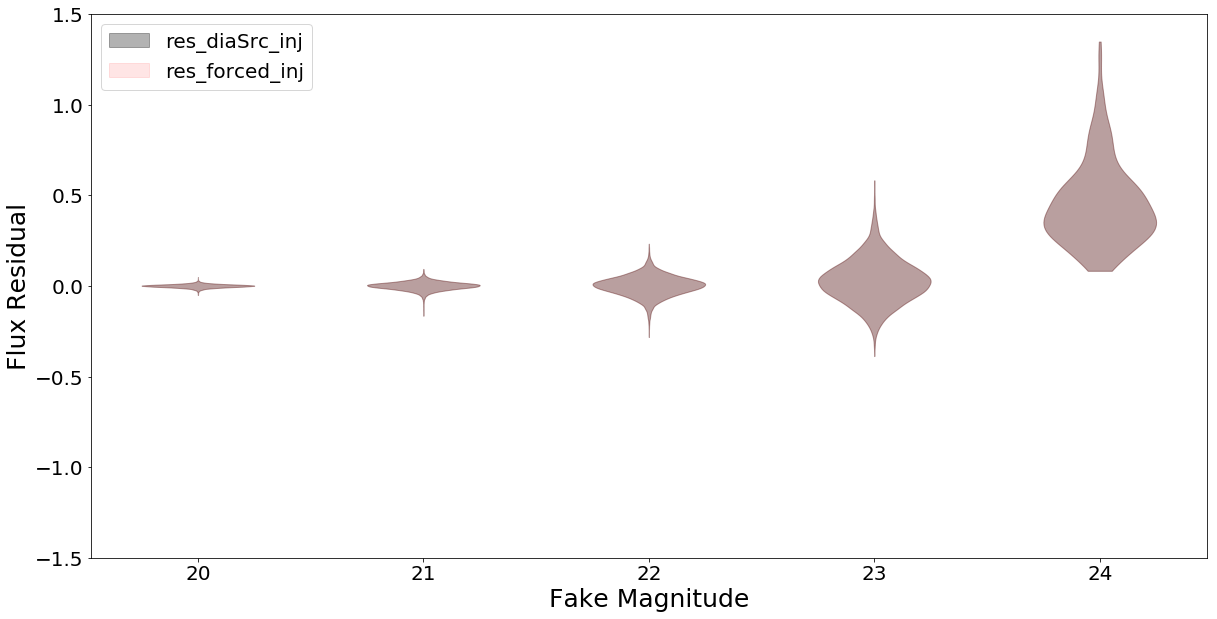

In [94]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

res_list = []
forced_res_list = []
for fake_idx, fake_mag in enumerate(fake_mag_list):
    res = get_residual(fake_src_det, fake_mag=str(fake_mag))
    forced_res = get_forced_residual(forced_flux_det, fake_mag=str(fake_mag))
    clipped = remove_outlier(res.array)
    forced_clipped = remove_outlier(forced_res.array)
    res_list.append(list(clipped))
    forced_res_list.append(list(forced_clipped))
parts_diaSrc = ax.violinplot(res_list, showmedians=False, showextrema=False)
parts_forced = ax.violinplot(forced_res_list, showmedians=False, showextrema=False)

for pc in parts_diaSrc['bodies']:
    pc.set_facecolor('black')
    pc.set_edgecolor('black')
for pc in parts_forced['bodies']:
    pc.set_facecolor('red')
    pc.set_edgecolor('red')
    pc.set_alpha(0.1)
add_label(parts_diaSrc, 'res_diaSrc_inj', labels)
add_label(parts_forced, 'res_forced_inj', labels)
# parts_forced['cmaxes'].set_color(['red', 'red', 'red', 'red'])
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(['20', '21', '22', '23', '24'], size=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel('Flux Residual', size=25)
ax.set_xlabel('Fake Magnitude', size=25)
ax.set_ylim((-1.5, 1.5))
plt.legend(*zip(*labels[0:2]), loc=2, fontsize=20)
plt.savefig('res.pdf', dpi=100)

https://stackoverflow.com/questions/33864578/matplotlib-making-labels-for-violin-plots
https://matplotlib.org/stable/gallery/statistics/customized_violin.html